<a href="https://www.kaggle.com/code/danuherath/titanic-survival-classification?scriptVersionId=189544178" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 align="center"> Titanic Disaster Survival Prediction (Binary Classification) </h1>

<img 
    src="https://www.kaggle.com/competitions/3136/images/header" 
    alt="" 
    width="500" 
    height="400" 
    style="display: block; margin: 0 auto; border-radius:15px" 
/>

---

## Problem Definition

- Dataset

    - [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/data?select=train.csv) Dataset from Kaggle which contains 10 features explaining passengers' demographics, cruise details etc. Train dataset contains 891 samples and each instance represents one passenger.

<br>

- Objective
    - The goal of this project is to predict whether a passenger survived the Titanic disaster based on the above features.

<br>

- Following classification algorithms are used to train models. The models are evaluated using the accuracy score.
- Top scoring models are used for hyperparameter tuning and training a [stacking classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) and a [voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html).

    1. [Logistic Regression Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
    2. [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
    3. [K-Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
    4. [Gaussian Naive Bayes Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)
    5. [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
    6. [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
    7. [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)
    8. [Adaboost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
    9. [Neural Network](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import optuna


In [2]:
train_data_original = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data_original = pd.read_csv('/kaggle/input/titanic/test.csv')
train_data = train_data_original.copy()
test_data = test_data_original.copy()


In [3]:
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S



---

# Step 1: Exploratory Data Analysis (EDA)¶

---


## Data Dictionary:

| Variable | Definition | Key |
|----------|----------|----------|
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Gender |  |
| Age | Age in years |  |
| sibsp | # of siblings/ spouses aboard the Titanic |  |
| parch | # of parents / children aboard the Titanic |  |
| ticket | Ticket number |  |
| fare | Passenger fare |  |
| cabin | Cabin number |  |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |


## Variable Notes:
* pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower
* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
* sibsp: The dataset defines family relations in this way
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)
* parch: The dataset defines family relations in this way
    - Parent = mother, father
    - Child = daughter, son, stepdaughter, stepson
    - Some children travelled only with a nanny, therefore parch=0 for them.


In [5]:
train_data.drop(columns='PassengerId', inplace=True)
print(f"Train data rows and columns: {train_data.shape}")
test_data.drop(columns='PassengerId', inplace=True)
print(f"Train data rows and columns: {test_data.shape}")

Train data rows and columns: (891, 11)
Train data rows and columns: (418, 10)


In [6]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [7]:
missing_values = train_data.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(f"Missing value count - Train data: \n{missing_values}\n")

missing_values = test_data.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(f"Missing value count - Test data: \n{missing_values}")

Missing value count - Train data: 
Cabin       687
Age         177
Embarked      2
dtype: int64

Missing value count - Test data: 
Cabin    327
Age       86
Fare       1
dtype: int64


In [8]:
train_data.nunique()


Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

In [9]:
train_data.duplicated().sum()


0

In [10]:
train_data.dtypes


Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [11]:
test_data.dtypes


Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [12]:
train_data.columns


Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
cat_features = ['Pclass', 'Sex', 'Embarked']
num_features = ['Age', 'Fare', 'SibSp', 'Parch']
features_to_drop = ['Name', 'Ticket', 'Cabin']
target = 'Survived'


In [14]:
train_data[cat_features].dtypes


Pclass       int64
Sex         object
Embarked    object
dtype: object

In [15]:
train_data[num_features].dtypes


Age      float64
Fare     float64
SibSp      int64
Parch      int64
dtype: object

In [16]:
train_data[target].value_counts()


Survived
0    549
1    342
Name: count, dtype: int64

## 1.1 Statistical Analysis


In [17]:
train_data[num_features].describe()


,Age,Fare,SibSp,Parch
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.523008,0.381594
std,14.526497,49.693429,1.102743,0.806057
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,0.000000
50%,28.000000,14.454200,0.000000,0.000000
75%,38.000000,31.000000,1.000000,0.000000
max,80.000000,512.329200,8.000000,6.000000


In [18]:
Q1 = train_data[num_features].quantile(0.25)
Q3 = train_data[num_features].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = ((train_data[num_features] < lower_bound) | (train_data[num_features] > upper_bound))

outliers_count = outliers_iqr.sum()
outliers_count = outliers_count[outliers_count > 0].sort_values(ascending=False)
print(f"Outliers Count: \n{outliers_count}")


cols_with_outliers = list(outliers_count.index)
print(f"\nColumns with Outliers: \n{cols_with_outliers}")


Outliers Count: 
Parch    213
Fare     116
SibSp     46
Age       11
dtype: int64

Columns with Outliers: 
['Parch', 'Fare', 'SibSp', 'Age']


## 1.2 Data Visualization


### 1.2.1 Univariate Analysis


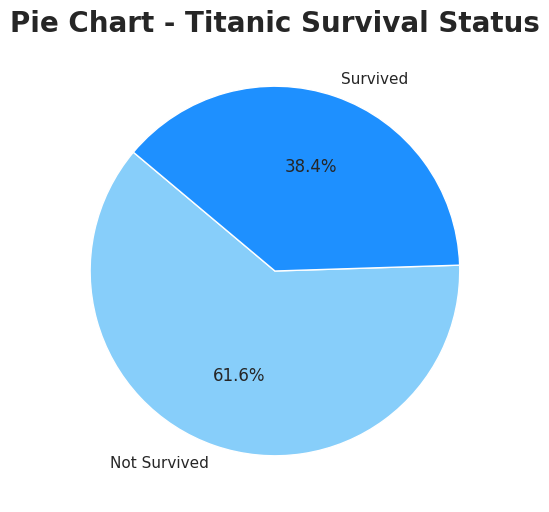

In [19]:
value_counts = train_data[target].value_counts()

sns.set_theme()
plt.figure(figsize=(8, 6))
palette = ['lightskyblue', 'dodgerblue']

plt.pie(value_counts, labels=['Not Survived', 'Survived'], autopct='%1.1f%%', startangle=140, colors=palette)
plt.title('Pie Chart - Titanic Survival Status', fontsize=20, weight='bold')

plt.savefig('Pie Chart - Titanic Survival Status.png')
plt.show()


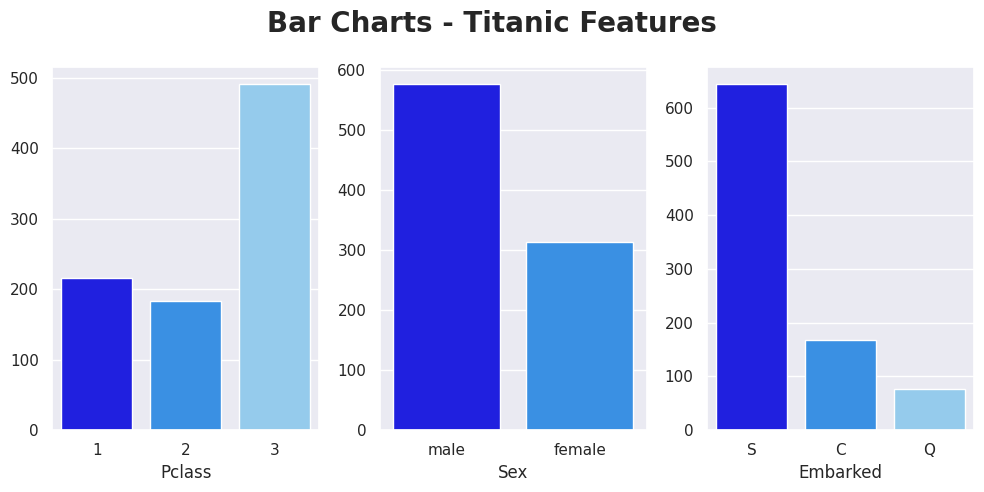

In [20]:
n_rows = 1
n_cols = 3
palette = ['blue', 'dodgerblue', 'lightskyblue']

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5*n_rows))
fig.tight_layout(pad=4.0)

for i, column in enumerate(train_data[cat_features].columns):
    ax = axes[i]
    category_counts = train_data[cat_features][column].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, palette=palette)


plt.suptitle('Bar Charts - Titanic Features', fontsize=20, weight='bold')
plt.tight_layout()

plt.savefig('Bar Charts - Titanic Features')
plt.show()


In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


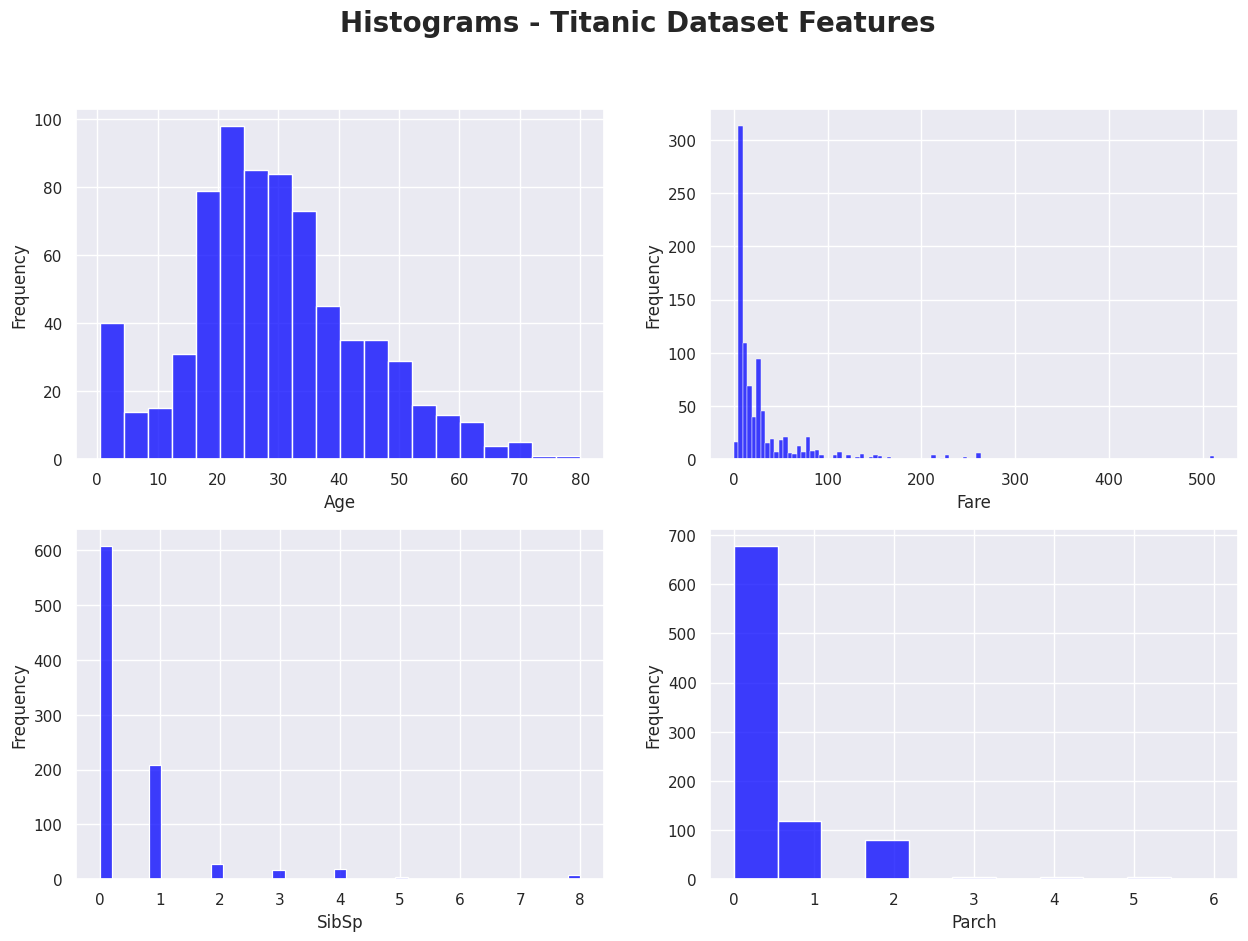

In [22]:
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()


for i, col in enumerate(train_data[num_features].columns):
    ax = axes[i]
    sns.histplot(train_data[num_features][col], ax=ax, color='blue')
    ax.set_ylabel('Frequency')

plt.suptitle('Histograms - Titanic Dataset Features', fontsize=20, weight='bold')

plt.savefig('Histograms - Titanic Dataset Features.png')
plt.show()


### 1.2.2 Bivariate Analysis


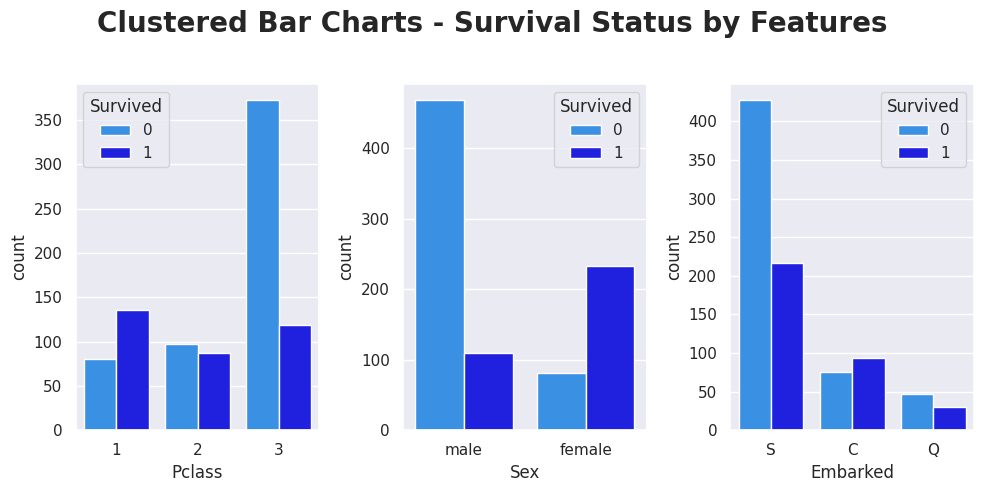

In [23]:
n_rows = 1
n_cols = 3
palette = ['dodgerblue', 'blue']

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5*n_rows))
fig.tight_layout(pad=4.0)

for i, column in enumerate(cat_features):
    ax = axes[i]
    sns.countplot(data=train_data, x=column, hue='Survived', palette=palette, ax=ax)

plt.suptitle('Clustered Bar Charts - Survival Status by Features', fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('Clustered Bar Charts - Titanic Features.png')
plt.show()


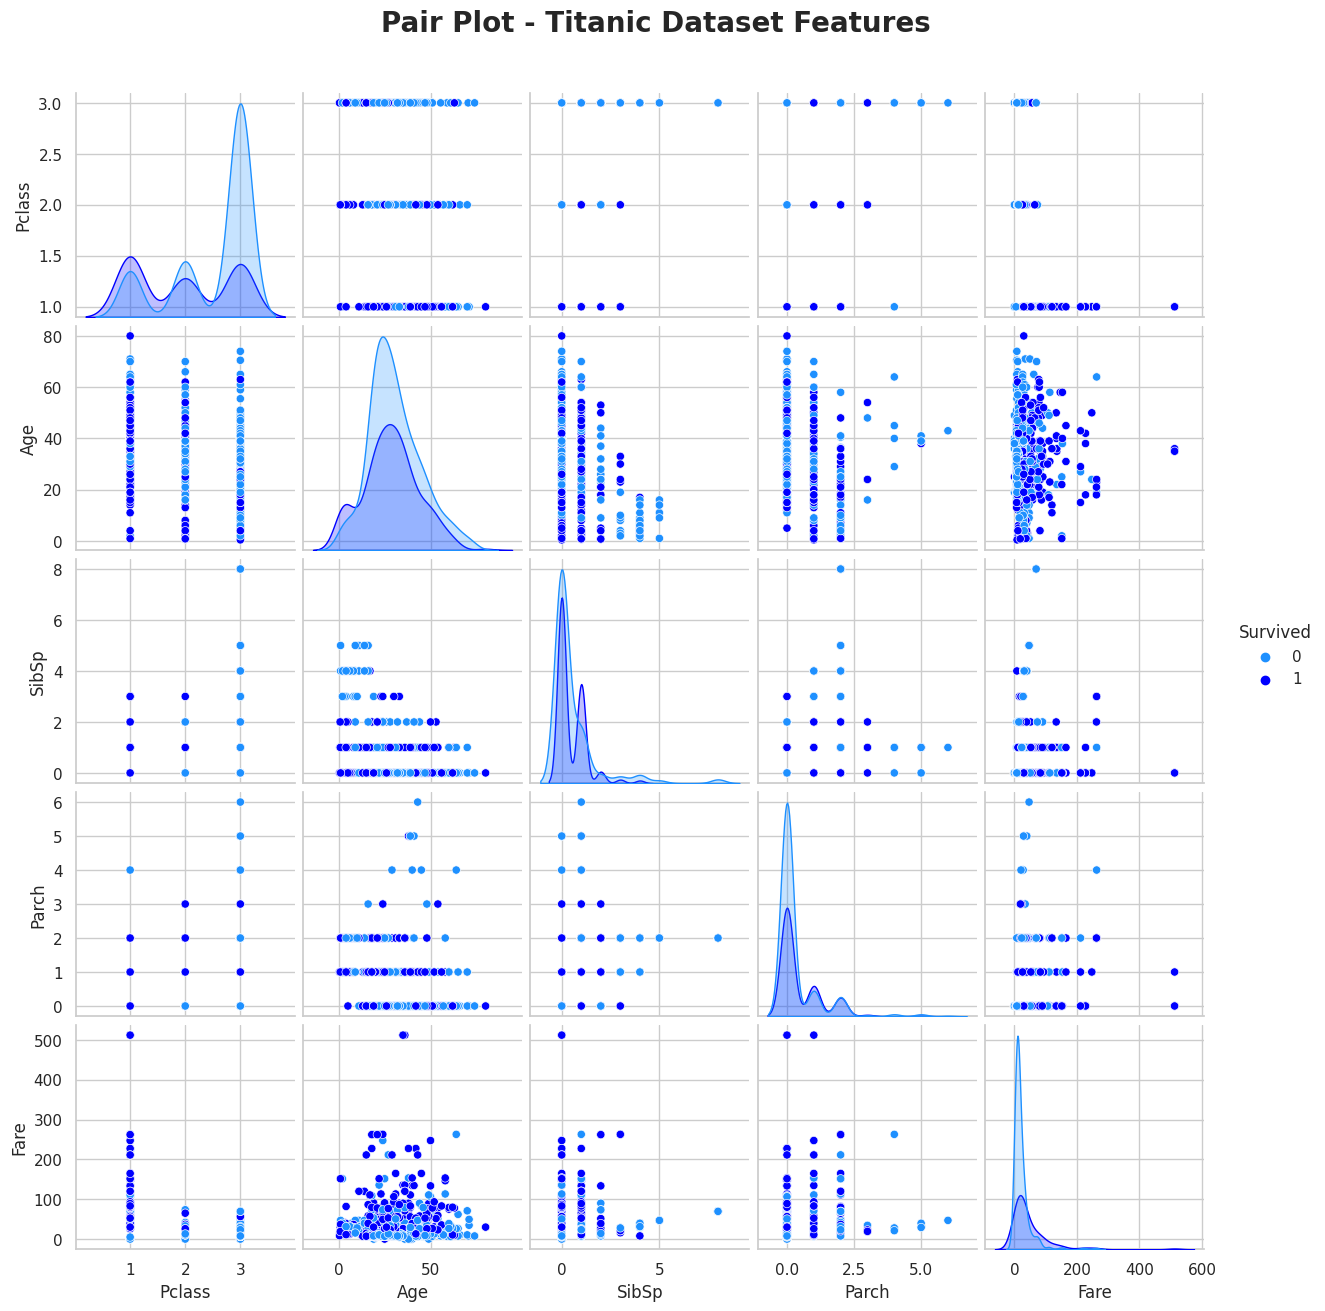

In [24]:
sns.set(style="whitegrid")
palette = ['dodgerblue', 'blue']

sns.pairplot(train_data, hue='Survived', palette=palette)
plt.suptitle('Pair Plot - Titanic Dataset Features', y=1.05, fontsize=20, weight='bold')

plt.savefig('Pair Plot - Titanic Dataset Features.png')
plt.show()


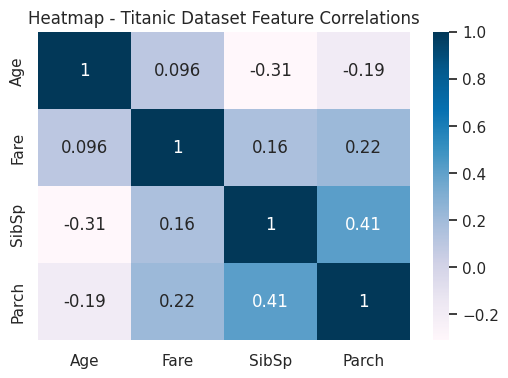

In [25]:
corr = train_data[num_features].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='PuBu')
plt.title('Heatmap - Titanic Dataset Feature Correlations')

plt.savefig('Titanic Dataset Feature Correlations.png')
plt.show()


### Conclusion:¶

* No duplicated rows are prsent
* No inconsistent labels in the Target column
* 'Age', 'Cabin', 'Embarked' columns have null values
* 'Age', 'SibSp', 'Parch', 'Fare' features contain numerical data
* 'Pclass', 'Sex', 'Embarked' features contain categorical data
* 'PassengerId', 'Name', 'Ticket' features are not important for model training
* 'Age', 'SibSp', 'Parch', 'Fare' features has outliers

<br>



---

# Step 2. Data Cleaning & Feature Engineering

---


In [26]:
train_data.drop(features_to_drop, axis=1, inplace=True)
test_data.drop(features_to_drop, axis=1, inplace=True)


In [27]:
# Add new feature 'Family' summing up 'Sibsp' and 'Parch' features
train_data['Family'] = train_data['SibSp'] + train_data['Parch']
train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
train_data.head()


,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [28]:
test_data['Family'] = test_data['SibSp'] + test_data['Parch']
test_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
test_data.head()


,Pclass,Sex,Age,Fare,Embarked,Family
0,3,male,34.5,7.8292,Q,0
1,3,female,47.0,7.0000,S,1
2,2,male,62.0,9.6875,Q,0
3,3,male,27.0,8.6625,S,0
4,3,female,22.0,12.2875,S,2



---

# Step 3. Data Pre-processing

---


In [29]:
train_data['Pclass'] = pd.Categorical(train_data['Pclass'], ordered=True)
train_data['Sex'] = pd.Categorical(train_data['Sex'])
train_data['Embarked'] = pd.Categorical(train_data['Embarked'])
train_data['Survived'] = pd.Categorical(train_data['Survived'])
train_data.dtypes


Survived    category
Pclass      category
Sex         category
Age          float64
Fare         float64
Embarked    category
Family         int64
dtype: object

In [30]:
test_data['Pclass'] = pd.Categorical(test_data['Pclass'], ordered=True)
test_data['Sex'] = pd.Categorical(test_data['Sex'])
test_data['Embarked'] = pd.Categorical(test_data['Embarked'])
test_data.dtypes


Pclass      category
Sex         category
Age          float64
Fare         float64
Embarked    category
Family         int64
dtype: object

In [31]:
numerical_cols = ['Age', 'Fare', 'Family']
categorical_cols = ['Pclass', 'Sex', 'Embarked']


preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), numerical_cols),
        ('categorical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_cols)
    ],
    remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['Age', 'Fare', 'Family']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Pclass', 'Sex', 'Embarked'])])

In [32]:
X = train_data.drop(columns=['Survived'])
y = train_data['Survived']



--- 

# Step 4. Model Training & Evaluation

---


In [33]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Neural Network': MLPClassifier(max_iter=2000, random_state=42)
}


In [34]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold

def train_models(X, y, models, preprocessor, cv_folds=5):
    results = {}
    skf = StratifiedKFold(n_splits=cv_folds)
    
    for name, model in models.items():
        pipeline = make_pipeline(preprocessor, model)

        y_pred = cross_val_predict(pipeline, X, y, cv=skf)

        print(f"Classification Report for {name} with {cv_folds}-fold Cross-Validation:")
        print(classification_report(y, y_pred))
        print('\n')

        cv_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy')
        mean_cv_accuracy = cv_scores.mean()
        results[name] = mean_cv_accuracy 

    return results


scores = train_models(X, y, models, preprocessor)


Classification Report for Logistic Regression with 5-fold Cross-Validation:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       549
           1       0.76      0.69      0.73       342

    accuracy                           0.80       891
   macro avg       0.79      0.78      0.78       891
weighted avg       0.80      0.80      0.80       891



Classification Report for Support Vector Machine with 5-fold Cross-Validation:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       549
           1       0.79      0.72      0.75       342

    accuracy                           0.82       891
   macro avg       0.81      0.80      0.81       891
weighted avg       0.82      0.82      0.82       891



Classification Report for K-Nearest Neighbors with 5-fold Cross-Validation:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       549
  

In [35]:
sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))

print("Sorted Scores:")
for model, score in sorted_scores.items():
    print(f'{model}: {score:.4f}')


Sorted Scores:
Gradient Boosting: 0.8294
Support Vector Machine: 0.8193
AdaBoost: 0.8093
Neural Network: 0.8081
Random Forest: 0.8059
Logistic Regression: 0.7991
K-Nearest Neighbors: 0.7958
Naive Bayes: 0.7835
Decision Tree: 0.7835


## 4.1 Hyperparameter Tuning


In [36]:

def objective(trial, X, y, preprocessor, cv_folds=5):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None]),
        'random_state':42
    }

    model = GradientBoostingClassifier(**param)
    pipeline = make_pipeline(preprocessor, model)
    
    skf = StratifiedKFold(n_splits=cv_folds)
    cv_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy')
    
    return cv_scores.mean()


def tune_gradient_boosting(X, y, preprocessor, n_trials=100, cv_folds=5):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y, preprocessor, cv_folds), n_trials=n_trials)
    
    print(f'Best trial: {study.best_trial.params}')
    
    best_model = GradientBoostingClassifier(**study.best_trial.params, random_state=42)
    return best_model


best_gb_model = tune_gradient_boosting(X, y, preprocessor)
best_gb_model


[I 2024-07-24 06:29:06,580] A new study created in memory with name: no-name-5b6ba74a-1c6c-41b9-bb91-6feff1517293
[I 2024-07-24 06:29:10,413] Trial 0 finished with value: 0.8316740945326722 and parameters: {'n_estimators': 284, 'learning_rate': 0.016474865441330887, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 1, 'subsample': 0.767326202199639, 'max_features': 'log2'}. Best is trial 0 with value: 0.8316740945326722.
[I 2024-07-24 06:29:11,201] Trial 1 finished with value: 0.8226727763480006 and parameters: {'n_estimators': 83, 'learning_rate': 0.014917408480199266, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 17, 'subsample': 0.9939597725062863, 'max_features': 'log2'}. Best is trial 0 with value: 0.8316740945326722.
[I 2024-07-24 06:29:12,515] Trial 2 finished with value: 0.824938798568828 and parameters: {'n_estimators': 164, 'learning_rate': 0.03207930039857066, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 12, 'subsample': 0.6423897322

Best trial: {'n_estimators': 190, 'learning_rate': 0.03977763172208959, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 12, 'subsample': 0.7024126882268148, 'max_features': 'auto'}


GradientBoostingClassifier(learning_rate=0.03977763172208959, max_depth=5,
                           max_features='auto', min_samples_leaf=12,
                           min_samples_split=11, n_estimators=190,
                           random_state=42, subsample=0.7024126882268148)

In [37]:

def objective(trial, X, y, preprocessor, cv_folds=5):
    
    param = {
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['sgd', 'adam']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-5, 1e-1, log=True),
        'max_iter': 2000,
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': 10,
        'tol': 1e-4,
        'random_state': 42
    }

    model = MLPClassifier(**param)
    pipeline = make_pipeline(preprocessor, model)
    
    skf = StratifiedKFold(n_splits=cv_folds)
    cv_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy')
    
    return cv_scores.mean()


def tune_mlp_classifier(X, y, preprocessor, n_trials=100, cv_folds=5):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y, preprocessor, cv_folds), n_trials=n_trials)
    
    print(f'Best trial: {study.best_trial.params}')
    
    best_model = MLPClassifier(**study.best_trial.params, random_state=42)
    return best_model


best_mlp_model = tune_mlp_classifier(X, y, preprocessor)
best_mlp_model


[I 2024-07-24 06:32:12,913] A new study created in memory with name: no-name-52df1e8e-8fd8-4ea5-a5fc-55d8170d5616
[I 2024-07-24 06:32:13,504] Trial 0 finished with value: 0.3747787332873015 and parameters: {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.061343856755738176, 'learning_rate': 'constant', 'learning_rate_init': 5.1719886887000875e-05}. Best is trial 0 with value: 0.3747787332873015.
[I 2024-07-24 06:32:14,214] Trial 1 finished with value: 0.40625196158433247 and parameters: {'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0015592623970473484, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001985018144931492}. Best is trial 1 with value: 0.40625196158433247.
[I 2024-07-24 06:32:15,480] Trial 2 finished with value: 0.7979976147134518 and parameters: {'activation': 'tanh', 'solver': 'adam', 'alpha': 1.0187298953566852e-05, 'learning_rate': 'constant', 'learning_rate_init': 0.010699565325838312}. Best is trial 2 with value: 0.7979976147134518.
[I 2024-07-24 06:32:1

Best trial: {'activation': 'relu', 'solver': 'adam', 'alpha': 3.0672945179452236e-05, 'learning_rate': 'constant', 'learning_rate_init': 0.07993689021033332}


MLPClassifier(alpha=3.0672945179452236e-05,
              learning_rate_init=0.07993689021033332, random_state=42)

In [38]:

def objective(trial, X, y, preprocessor, cv_folds=5):
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    
    param = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e3),
        'kernel': kernel,
        'random_state':42
    }
    
    if kernel in ['rbf', 'poly', 'sigmoid']:
        param['gamma'] = trial.suggest_loguniform('gamma', 1e-4, 1e1)
    else:
        param['gamma'] = 'scale'
    
    if kernel == 'poly':
        param['degree'] = trial.suggest_int('degree', 2, 5)
    else:
        param['degree'] = 3
    
    model = SVC(**param)
    pipeline = make_pipeline(preprocessor, model)
    
    skf = StratifiedKFold(n_splits=cv_folds)
    cv_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy')
    
    return cv_scores.mean()


def tune_svc(X, y, preprocessor, n_trials=20, cv_folds=5):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y, preprocessor, cv_folds), n_trials=n_trials)
    
    print(f'Best trial: {study.best_trial.params}')
    
    best_model = SVC(**study.best_trial.params, random_state=42)
    return best_model


best_svc_model = tune_svc(X, y, preprocessor)
best_svc_model


[I 2024-07-24 06:34:07,906] A new study created in memory with name: no-name-5cf916d7-01e5-4aa2-891c-8577312afd43
[I 2024-07-24 06:34:08,113] Trial 0 finished with value: 0.6161634548992531 and parameters: {'kernel': 'poly', 'C': 0.002754743092044983, 'gamma': 0.0036997096341899087, 'degree': 2}. Best is trial 0 with value: 0.6161634548992531.
[I 2024-07-24 06:34:08,358] Trial 1 finished with value: 0.7755194275312285 and parameters: {'kernel': 'sigmoid', 'C': 866.8288069890822, 'gamma': 0.0015317014574669431}. Best is trial 1 with value: 0.7755194275312285.
[I 2024-07-24 06:34:08,679] Trial 2 finished with value: 0.7878601468834348 and parameters: {'kernel': 'linear', 'C': 5.3102841301325014}. Best is trial 2 with value: 0.7878601468834348.
[I 2024-07-24 06:34:08,927] Trial 3 finished with value: 0.5645408323394638 and parameters: {'kernel': 'sigmoid', 'C': 0.5342261106634127, 'gamma': 4.029189354311034}. Best is trial 2 with value: 0.7878601468834348.
[I 2024-07-24 06:34:09,183] Tria

Best trial: {'kernel': 'rbf', 'C': 23.503671630947363, 'gamma': 0.02098077905691606}


SVC(C=23.503671630947363, gamma=0.02098077905691606, random_state=42)

In [39]:

def objective(trial, X, y, preprocessor, cv_folds=5):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state':42
    }

    model = RandomForestClassifier(**param)
    pipeline = make_pipeline(preprocessor, model)
    
    skf = StratifiedKFold(n_splits=cv_folds)
    cv_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy')
    
    return cv_scores.mean()


def tune_random_forest(X, y, preprocessor, n_trials=100, cv_folds=5):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y, preprocessor, cv_folds), n_trials=n_trials)
    
    print(f'Best trial: {study.best_trial.params}')

    best_model = RandomForestClassifier(**study.best_trial.params, random_state=42)
    return best_model


best_rf_model = tune_random_forest(X, y, preprocessor)
best_rf_model


[I 2024-07-24 06:34:54,448] A new study created in memory with name: no-name-e9c3441a-afa8-4934-a1c1-37da9ceecc78
[I 2024-07-24 06:34:55,991] Trial 0 finished with value: 0.8148578243675851 and parameters: {'n_estimators': 179, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8148578243675851.
[I 2024-07-24 06:34:57,168] Trial 1 finished with value: 0.8226916075575922 and parameters: {'n_estimators': 93, 'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.8226916075575922.
[I 2024-07-24 06:34:57,834] Trial 2 finished with value: 0.8227041616973197 and parameters: {'n_estimators': 62, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.8227041616973197.
[I 2024-07-24 06:34:59,079] Trial 3 finished with value: 0.806992655828259

Best trial: {'n_estimators': 58, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}


RandomForestClassifier(max_depth=9, max_features=None, min_samples_split=7,
                       n_estimators=58, random_state=42)

In [40]:
def create_stacking_classifier(X, y, preprocessor):
    gb_model = best_gb_model
    mlp_model = best_mlp_model
    rf_model = best_rf_model
    svc_model = best_svc_model

    base_models = [
        ('gb', gb_model),
        ('mlp', mlp_model),
        ('rf', rf_model)
    ]
    
    meta_model = svc_model
    
    stacking_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model
    )
    
    pipeline = make_pipeline(preprocessor, stacking_clf)
    
    return pipeline


stacking_model_pipeline = create_stacking_classifier(X, y, preprocessor)
stacking_model_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare', 'Family']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_un...
                                                                            random_state=42,
                                                                            subsample=0.7024126882268148)),
                                                ('mlp',
                                                 MLPClassifier(alpha=3.0672945179452236e-05,
                                                               learning_rate_init=0.07993689021033332,
                                                               random_state=42)),
                                                ('rf',
                                                 RandomForestClassifier(max_depth=9,
                                                                        max_features=None,
                                                                        min_samples_split=7,
                                                                        n_estimators=58,
                                                                        random_state=42))],
                                    final_estimator=SVC(C=23.503671630947363,
                                                        gamma=0.02098077905691606,
                                                        random_state=42)))])

In [41]:
def create_voting_classifier(X, y, preprocessor):
    gb_model = best_gb_model
    mlp_model = best_mlp_model
    rf_model = best_rf_model
    svc_model = best_svc_model

    base_models = [
        ('gb', gb_model),
        ('mlp', mlp_model),
        ('rf', rf_model),
        ('svc', svc_model)
    ]
    
    voting_clf = VotingClassifier(
        estimators=base_models,
        voting='hard'
    )
    
    pipeline = make_pipeline(preprocessor, voting_clf)
    
    return pipeline


voting_model_pipeline = create_voting_classifier(X, y, preprocessor)
voting_model_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare', 'Family']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_un...
                                                                          n_estimators=190,
                                                                          random_state=42,
                                                                          subsample=0.7024126882268148)),
                                              ('mlp',
                                               MLPClassifier(alpha=3.0672945179452236e-05,
                                                             learning_rate_init=0.07993689021033332,
                                                             random_state=42)),
                                              ('rf',
                                               RandomForestClassifier(max_depth=9,
                                                                      max_features=None,
                                                                      min_samples_split=7,
                                                                      n_estimators=58,
                                                                      random_state=42)),
                                              ('svc',
                                               SVC(C=23.503671630947363,
                                                   gamma=0.02098077905691606,
                                                   random_state=42))]))])

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
gb_pipeline = make_pipeline(preprocessor, best_gb_model)
gb_pipeline.fit(X_train, y_train)
y_pred = gb_pipeline.predict(X_val)

test_accuracy = accuracy_score(y_val, y_pred)
print("Gradient Boosting Test Accuracy:", test_accuracy)


Gradient Boosting Test Accuracy: 0.8268156424581006


In [44]:
mlp_pipeline = make_pipeline(preprocessor, best_mlp_model)
mlp_pipeline.fit(X_train, y_train)
y_pred = mlp_pipeline.predict(X_val)

test_accuracy = accuracy_score(y_val, y_pred)
print("Neural Network Test Accuracy:", test_accuracy)


Neural Network Test Accuracy: 0.7932960893854749


In [45]:
svc_pipeline = make_pipeline(preprocessor, best_svc_model)
svc_pipeline.fit(X_train, y_train)
y_pred = svc_pipeline.predict(X_val)

test_accuracy = accuracy_score(y_val, y_pred)
print("SVC Test Accuracy:", test_accuracy)


SVC Test Accuracy: 0.8044692737430168


In [46]:
rf_pipeline = make_pipeline(preprocessor, best_rf_model)
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_val)

test_accuracy = accuracy_score(y_val, y_pred)
print("Random Forest Test Accuracy:", test_accuracy)


Random Forest Test Accuracy: 0.8324022346368715


In [47]:
stacking_model_pipeline.fit(X_train, y_train)
y_pred = stacking_model_pipeline.predict(X_val)

test_accuracy = accuracy_score(y_val, y_pred)
print("Stacking Classifier Test Accuracy:", test_accuracy)


Stacking Classifier Test Accuracy: 0.8212290502793296


In [48]:
voting_model_pipeline.fit(X_train, y_train)
y_pred = voting_model_pipeline.predict(X_val)

test_accuracy = accuracy_score(y_val, y_pred)
print("Stacking Classifier Test Accuracy:", test_accuracy)


Stacking Classifier Test Accuracy: 0.8268156424581006



---

# Step 5. Model Prediction on Test Data

---


In [49]:
test_predictions = voting_model_pipeline.predict(test_data)


In [50]:
submission = pd.read_csv('/kaggle/input/titanic/test.csv')
submission['Survived'] = test_predictions
submission = submission[['PassengerId', 'Survived']]

submission.to_csv('submission.csv', index=False)

submission.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


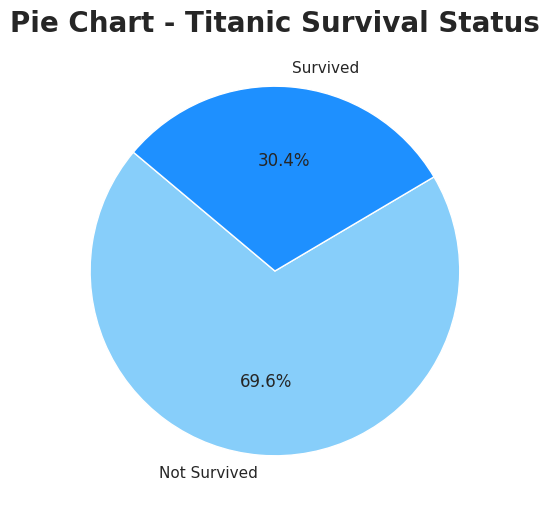

In [51]:
value_counts = submission[target].value_counts()

sns.set_theme()
plt.figure(figsize=(8, 6))
palette = ['lightskyblue', 'dodgerblue']

plt.pie(value_counts, labels=['Not Survived', 'Survived'], autopct='%1.1f%%', startangle=140, colors=palette)
plt.title('Pie Chart - Titanic Survival Status', fontsize=20, weight='bold')

plt.savefig('Pie Chart - Titanic Survival Status.png')
plt.show()
